Imports

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import LeaveOneOut
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns

/Users/olamakara/studia/semestr_8/mgu/lab4/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Preprocessing

In [3]:
def interpolate_position(segment, length=40):
    result = {}
    for axis in ['x', 'y', 'z']:
        f = interp1d(np.linspace(0, 1, len(segment)), segment[axis], kind='linear')
        result[axis] = f(np.linspace(0, 1, length))
    return pd.DataFrame(result)

from scipy.spatial.transform import Rotation as R, Slerp

def interpolate_quaternion(quat_array, length=40):
    t_original = np.linspace(0, 1, len(quat_array))
    t_new = np.linspace(0, 1, length)

    r = R.from_quat(quat_array)
    slerp = Slerp(t_original, r)
    interpolated = slerp(t_new)

    return interpolated.as_quat()

def preprocess_single_file(filepath, output_length=40):
    df = pd.read_csv(filepath, sep=';')
    pos = df[['RdevicePosition.x', 'RdevicePosition.y', 'RdevicePosition.z']]
    pos.columns = ['x', 'y', 'z']
    pos_interp = interpolate_position(pos, output_length)

    quat = df[['RdeviceRotation.x', 'RdeviceRotation.y', 'RdeviceRotation.z', 'RdeviceRotation.w']].to_numpy()
    quat_interp = interpolate_quaternion(quat, output_length)

    combined = np.hstack([pos_interp.to_numpy(), quat_interp])
    return combined

def preprocess_directory(folder_path, label):
    data, labels = [], []
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            full_path = os.path.join(folder_path, file)
            sample = preprocess_single_file(full_path)
            data.append(sample)
            labels.append(label)
    return np.array(data), np.array(labels)


<h2>Training model and accuracy</h2>

Epoch 1/70


/Users/olamakara/studia/semestr_8/mgu/lab4/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4250 - loss: 1.3253 - val_accuracy: 0.7288 - val_loss: 1.1555
Epoch 2/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6894 - loss: 1.0551 - val_accuracy: 0.6102 - val_loss: 0.8713
Epoch 3/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6534 - loss: 0.8140 - val_accuracy: 0.7288 - val_loss: 0.7003
Epoch 4/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7564 - loss: 0.6060 - val_accuracy: 0.8136 - val_loss: 0.5051
Epoch 5/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8350 - loss: 0.4394 - val_accuracy: 0.8136 - val_loss: 0.3898
Epoch 6/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8376 - loss: 0.4109 - val_accuracy: 0.8305 - val_loss: 0.3580
Epoch 7/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9120 - loss: 0.2763 - val_accuracy: 0.9153 - val_loss: 0.3050
Epoch 8/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9083 - loss: 0.2831 - val_accuracy: 0.9661 - val_loss: 0.1554
Ep

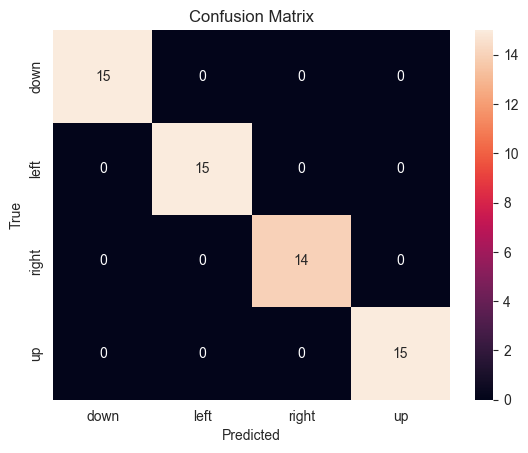

INFO:tensorflow:Assets written to: gesture_model_lstm_tf/assets


INFO:tensorflow:Assets written to: gesture_model_lstm_tf/assets


Saved artifact at 'gesture_model_lstm_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 7), dtype=tf.float32, name='keras_tensor_179')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  14325874752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13284442880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13627604656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13627855264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13630970688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13632381872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13632381520: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [34]:
base_path = "directions2"
classes = ["up", "down", "left", "right"]

# Przetwarzanie danych
all_data, all_labels = [], []
for label in classes:
    folder = os.path.join(base_path, label)
    data, labels = preprocess_directory(folder, label)
    all_data.append(data)
    all_labels.append(labels)

# Łączenie i kodowanie etykiet
X = np.vstack(all_data)
y = np.concatenate(all_labels)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Podział na zbiór treningowy i testowy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y
)

# Budowanie modelu
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(classes), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Trenowanie
history = model.fit(X_train, y_train, epochs=70, batch_size=16, validation_data=(X_test, y_test))

# Ewaluacja
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

# Macierz pomyłek
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

In [37]:
model.save("gesture_model_tf.keras")

In [ ]:
model.export("gesture_model_lstm_tf")

<h2>TMP - different model without LSTM</h2>

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2865 - loss: 1.3841 - val_accuracy: 0.4746 - val_loss: 1.3086
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4569 - loss: 1.2703 - val_accuracy: 0.5763 - val_loss: 1.2184
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4913 - loss: 1.2214 - val_accuracy: 0.5932 - val_loss: 1.1440
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5552 - loss: 1.1321 - val_accuracy: 0.5763 - val_loss: 1.0744
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6160 - loss: 1.0602 - val_accuracy: 0.5763 - val_loss: 1.0073
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5846 - loss: 1.0089 - val_accuracy: 0.5593 - val_loss: 0.9456
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6440 - loss: 0.9329 - val_accuracy: 0.5763 - val_loss: 0.8937
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6743 - loss: 0.8501 - val_accuracy: 0.6102 - val_loss: 0.8482

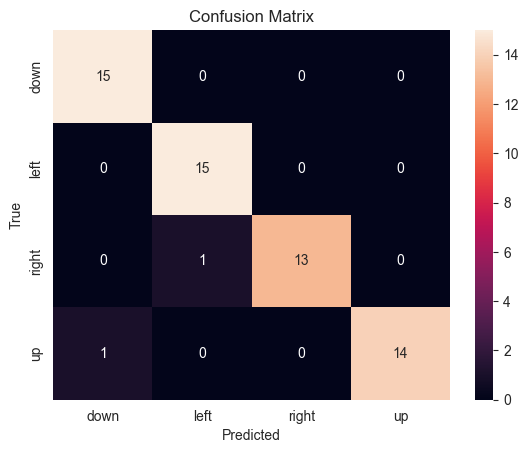

In [31]:
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.models import Model

base_path = "directions2"
classes = ["up", "down", "left", "right"]

# Przetwarzanie danych
all_data, all_labels = [], []
for label in classes:
    folder = os.path.join(base_path, label)
    data, labels = preprocess_directory(folder, label)
    all_data.append(data)
    all_labels.append(labels)

# Łączenie i kodowanie etykiet
X = np.vstack(all_data)
y = np.concatenate(all_labels)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Podział na zbiór treningowy i testowy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y
)

# Input shape: (40 timesteps, 7 features)
input_layer = Input(shape=(X.shape[1], X.shape[2]), name="input")
x = Conv1D(64, kernel_size=3, activation='relu')(input_layer)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax', name="output")(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

# Evaluate
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
